In [8]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from google.colab import drive
import os
import matplotlib.pyplot as plt
from keras.models import load_model

In [3]:
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/MyDrive/FYP")

Mounted at /content/gdrive


In [4]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
      
      # remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = 'Dataset/input-outputN.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'words-sents.pkl')
# spot check
for i in range(100):
	print('[%s] <= [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: words-sents.pkl
[go] <= [go]
[go] <= [go]
[go] <= [go]
[go] <= [go]
[hi] <= [hi]
[run] <= [run]
[run] <= [run]
[who] <= [who]
[fire] <= [fire]
[fire] <= [fire]
[fire] <= [fire]
[help] <= [help]
[help] <= [help]
[help] <= [help]
[jump] <= [jump]
[jump] <= [jump]
[stop] <= [stop]
[stop] <= [stop]
[stop] <= [stop]
[wait] <= [wait]
[wait] <= [wait]
[go on] <= [go on]
[go on] <= [go on]
[hello] <= [hello]
[i ran] <= [i ran]
[i ran] <= [i ran]
[i try] <= [i try]
[i won] <= [i won]
[oh no] <= [oh no]
[relax] <= [relax]
[smile] <= [smile]
[attack] <= [attack]
[attack] <= [attack]
[get up] <= [get up]
[go now] <= [go now]
[got it] <= [got it]
[got it] <= [got it]
[got it] <= [got it]
[he ran] <= [he ran]
[hop in] <= [hop in]
[hug me] <= [hug me]
[i fell] <= [i fell]
[i know] <= [i know]
[i left] <= [i left]
[i lied] <= [i lied]
[i lost] <= [i lost]
[i quit] <= [i quit]
[i quit] <= [i quit]
[i work] <= [i work]
[im] <= [im]
[im up] <= [im up]
[listen] <= [listen]
[listen] <= [listen]
[lis

In [5]:
from pickle import dump
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
#import load
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('words-sents.pkl')
 
# reduce dataset size
n_sentences = 25000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:23000], dataset[23000:]
print(len(train))
print(len(test))
# save
save_clean_data(dataset, 'words-sents-both.pkl')
save_clean_data(train, 'words-sents-train.pkl')
save_clean_data(test, 'words-sents-test.pkl')

23000
2000
Saved: words-sents-both.pkl
Saved: words-sents-train.pkl
Saved: words-sents-test.pkl


In [19]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(LSTM(n_units))
  #model.add(Dropout(0.5))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(n_units, return_sequences=True))
  #model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model
 
# load datasets
dataset = load_clean_sentences('words-sents-both.pkl')
train = load_clean_sentences('words-sents-train.pkl')
test = load_clean_sentences('words-sents-test.pkl')
 
# prepare words tokenizer
word_tokenizer = create_tokenizer(dataset[:, 0])
word_vocab_size = len(word_tokenizer.word_index) + 1
word_length = max_length(dataset[:, 0])
print('Words Vocabulary Size: %d' % word_vocab_size)
print('Words Max Length: %d' % (word_length))
# prepare sentences tokenizer
sent_tokenizer = create_tokenizer(dataset[:, 1])
sent_vocab_size = len(sent_tokenizer.word_index) + 1
sent_length = max_length(dataset[:, 1])
print('Sentences Vocabulary Size: %d' % sent_vocab_size)
print('Sentences Max Length: %d' % (sent_length))
 
# prepare training data
trainX = encode_sequences(sent_tokenizer, word_length, train[:, 1])
trainY = encode_sequences(word_tokenizer, word_length, train[:, 0])
trainY = encode_output(trainY, word_vocab_size)
# prepare validation data
testX = encode_sequences(sent_tokenizer, sent_length, test[:, 1])
testY = encode_sequences(word_tokenizer, word_length, test[:, 0])
testY = encode_output(testY, word_vocab_size)
 
# define model
model = define_model(sent_vocab_size, word_vocab_size, sent_length, word_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Words Vocabulary Size: 4404
Words Max Length: 7
Sentences Vocabulary Size: 4383
Sentences Max Length: 5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 256)            1122048   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 4404)           1131828   
Total params: 3,304,500
Trainable params: 3,304,500
Non-trainable params: 0
_________________________________________________________________
None
E

dict_keys(['loss', 'val_loss'])


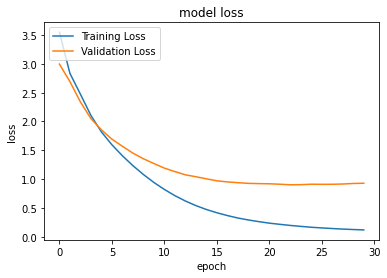

In [26]:
# list all data in history
epochList = list(range(0,31))
#print(epochList)
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [27]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)
 
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, word_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# load datasets
dataset = load_clean_sentences('words-sents-both.pkl')
train = load_clean_sentences('words-sents-train.pkl')
test = load_clean_sentences('words-sents-test.pkl')
# prepare word tokenizer
word_tokenizer = create_tokenizer(dataset[:, 0])
word_vocab_size = len(word_tokenizer.word_index) + 1
word_length = max_length(dataset[:, 0])
# prepare sentences tokenizer
sent_tokenizer = create_tokenizer(dataset[:, 1])
sent_vocab_size = len(sent_tokenizer.word_index) + 1
sent_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(sent_tokenizer, sent_length, train[:, 1])
testX = encode_sequences(sent_tokenizer, sent_length, test[:, 1])
 
# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, word_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, word_tokenizer, testX, test)

train
src=[tom waved mary], target=[tom waved to mary], predicted=[tom waved at mary]
src=[be nice her], target=[be nice to her], predicted=[be nice to her]
src=[i almost ready], target=[i am almost ready], predicted=[i am almost ready]
src=[dont cry], target=[dont cry], predicted=[dont cry]
src=[youre nuts], target=[youre nuts], predicted=[youre nuts]
src=[the earth rotates], target=[the earth rotates], predicted=[the earth rotates]
src=[i got thirsty], target=[i got thirsty], predicted=[i got thirsty]
src=[i crossed street], target=[i crossed the street], predicted=[i crossed the street]
src=[thats troubling], target=[thats troubling], predicted=[thats troubling]
src=[tom correct], target=[tom is correct], predicted=[tom is correct]
BLEU-1: 0.941299
BLEU-2: 0.893648
BLEU-3: 0.849098
BLEU-4: 0.703842
test
src=[are japanese], target=[are you japanese], predicted=[are you japanese]
src=[i liked it], target=[i liked it], predicted=[i liked it]
src=[tom desperate], target=[tom was despera